Preparing Data And Preprocessing

2025-02-24 16:24:54.508841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740394494.560898   37050 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740394494.575876   37050 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 16:24:54.691283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was r

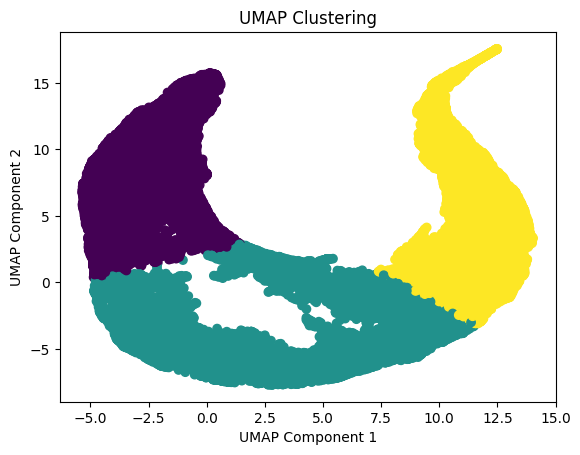

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap

# ---- STEP 1: LOAD DATA ----
df = pd.read_excel('./data_files/Data_re.xlsx')  # Ensure the file exists

# ---- STEP 2: FEATURE SELECTION ----
cols_to_keep = ['g_flux', 'r_flux', 'i_flux', 'y_flux', 'z_flux', 'specz_redshift']
df_selected = df[cols_to_keep].copy()

# Compute Flux Color Indices
df_selected['g_r'] = df_selected['g_flux'] - df_selected['r_flux']
df_selected['r_i'] = df_selected['r_flux'] - df_selected['i_flux']
df_selected['i_y'] = df_selected['i_flux'] - df_selected['y_flux']
df_selected['y_z'] = df_selected['y_flux'] - df_selected['z_flux']

# ---- STEP 3: REMOVE OUTLIERS ----
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)
outlier_scores = lof.fit_predict(df_selected.drop(columns=['specz_redshift']))
df_clean = df_selected[outlier_scores == 1].copy()

# ---- STEP 4: SCALING & TRANSFORMING ----
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clean.drop(columns=['specz_redshift']))

# Apply Power Transformation (Yeo-Johnson for normalizing skewed data)
power_transformer = PowerTransformer(method='yeo-johnson')
df_transformed = power_transformer.fit_transform(df_scaled)

# ---- STEP 5: DIMENSIONALITY REDUCTION WITH UMAP ----
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(df_transformed)

# ---- STEP 6: OPTIONAL PCA FOR EXPLORATION ----
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_transformed)

# ---- STEP 7: CLUSTERING ----
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_umap)

# ---- PLOT RESULTS ----
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_clean['Cluster'], cmap='viridis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Clustering')
plt.show()


checking 

In [3]:
print(df.head())
print(df.info())
print(df.describe())

                                               coord       dec  \
0   b'(179325.3125, 99694.8046875, -21178.96484375)' -5.893433   
1  b'(179236.609375, 99349.8203125, -23431.181640... -6.522742   
2     b'(179281.5, 99283.5078125, -23368.759765625)' -6.505290   
3  b'(179365.171875, 99158.046875, -23259.0839843... -6.474628   
4      b'(179366.421875, 99172.25, -23188.84765625)' -6.454993   

   g_central_image_pop_10px_rad  g_central_image_pop_15px_rad  \
0                             1                             1   
1                             1                             1   
2                             1                             1   
3                             1                             1   
4                             1                             1   

   g_central_image_pop_5px_rad  g_cmodel_mag  g_cmodel_magsigma  \
0                            1     20.314907           0.002624   
1                            1     22.217360           0.010902   
2          

Clustering (DBScan, K means and Gaussian Mixture Method)

Optimal eps for DBSCAN: 0.323
Optimal k for K-Means/GMM: 4
Silhouette Scores - KMeans: 0.486, GMM: 0.455, DBSCAN: -0.422


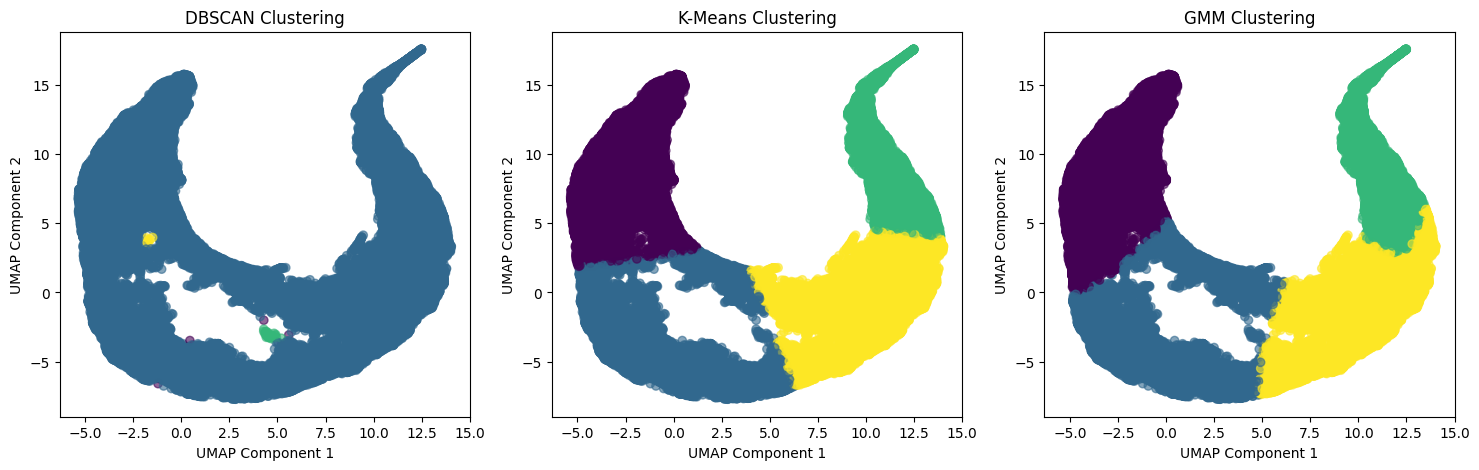

In [4]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from kneed import KneeLocator

# ---- STEP 6: DETERMINE OPTIMAL DBSCAN EPS ----
k = 5  # Typically, min_samples value
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(X_umap)
distances, indices = nearest_neighbors.kneighbors(X_umap)

# Sort distances to find the "knee" point
distances = np.sort(distances[:, -1])

# Use KneeLocator to find optimal epsilon
knee_locator = KneeLocator(range(len(distances)), distances, curve="convex", direction="increasing")
optimal_eps = distances[knee_locator.elbow]
print(f"Optimal eps for DBSCAN: {optimal_eps:.3f}")

# ---- STEP 6A: APPLY DBSCAN CLUSTERING WITH OPTIMAL EPS ----
dbscan = DBSCAN(eps=optimal_eps, min_samples=k, metric='euclidean')
cluster_labels_dbscan = dbscan.fit_predict(X_umap)
df_clean.loc[:, 'cluster_dbscan'] = cluster_labels_dbscan

# ---- STEP 6B: APPLY K-MEANS & GMM ----
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_umap)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X_umap, labels)
    silhouette_scores.append(score)

knee_locator = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
optimal_k = knee_locator.elbow
print(f"Optimal k for K-Means/GMM: {optimal_k}")

# Apply K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df_clean.loc[:, 'cluster_kmeans'] = kmeans.fit_predict(X_umap)

# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
df_clean.loc[:, 'cluster_gmm'] = gmm.fit_predict(X_umap)

# ---- STEP 7: COMPUTE SILHOUETTE SCORES ----
silhouette_kmeans = silhouette_score(X_umap, df_clean['cluster_kmeans'])
silhouette_gmm = silhouette_score(X_umap, df_clean['cluster_gmm'])
silhouette_dbscan = silhouette_score(X_umap[df_clean['cluster_dbscan'] != -1], 
                                     df_clean['cluster_dbscan'][df_clean['cluster_dbscan'] != -1])

print(f"Silhouette Scores - KMeans: {silhouette_kmeans:.3f}, GMM: {silhouette_gmm:.3f}, DBSCAN: {silhouette_dbscan:.3f}")

# ---- STEP 8: VISUALIZE CLUSTERING METHODS (2D PLOTS) ----
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# DBSCAN 2D Plot
ax[0].scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels_dbscan, cmap='viridis', alpha=0.6)
ax[0].set_title("DBSCAN Clustering")
ax[0].set_xlabel("UMAP Component 1")
ax[0].set_ylabel("UMAP Component 2")

# K-Means 2D Plot
ax[1].scatter(X_umap[:, 0], X_umap[:, 1], c=df_clean['cluster_kmeans'], cmap='viridis', alpha=0.6)
ax[1].set_title("K-Means Clustering")
ax[1].set_xlabel("UMAP Component 1")
ax[1].set_ylabel("UMAP Component 2")

# GMM 2D Plot
ax[2].scatter(X_umap[:, 0], X_umap[:, 1], c=df_clean['cluster_gmm'], cmap='viridis', alpha=0.6)
ax[2].set_title("GMM Clustering")
ax[2].set_xlabel("UMAP Component 1")
ax[2].set_ylabel("UMAP Component 2")

plt.show()


Random Forest

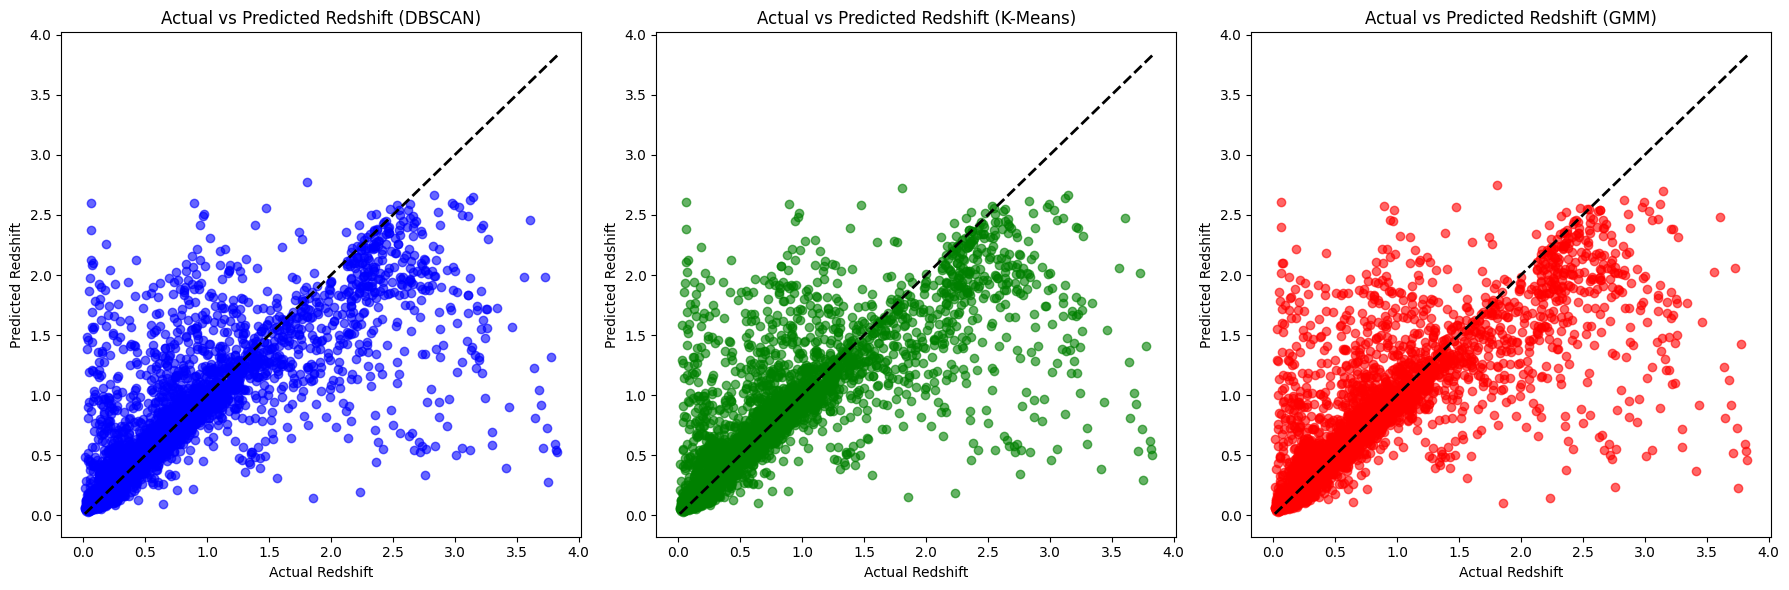

Random Forest Regression Results:
CLUSTER_DBSCAN - MSE: 0.103494, R2: 0.673538
CLUSTER_KMEANS - MSE: 0.103177, R2: 0.674537
CLUSTER_GMM - MSE: 0.103596, R2: 0.673214


In [5]:
# ---- STEP 8: RANDOM FOREST REGRESSION ----
# Train separate Random Forest models for each clustering method using flux features

results = {}

for cluster_type in ['cluster_dbscan', 'cluster_kmeans', 'cluster_gmm']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp[['g_flux', 'r_flux', 'i_flux', 'y_flux', 'z_flux'] + 
                [col for col in df_temp.columns if col.startswith(f'clust_{cluster_type}')]]
    y = df_temp['specz_redshift']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 9: VISUALIZE REGRESSION RESULTS ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
titles = ['DBSCAN', 'K-Means', 'GMM']
colors = ['blue', 'green', 'red']

for i, cluster_type in enumerate(results.keys()):
    ax[i].scatter(y_test, results[cluster_type]['y_pred'], alpha=0.6, color=colors[i])
    ax[i].set_xlabel('Actual Redshift')
    ax[i].set_ylabel('Predicted Redshift')
    ax[i].set_title(f'Actual vs Predicted Redshift ({titles[i]})')
    ax[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.tight_layout()
plt.show()

# ---- STEP 10: COMPARE RESULTS ACROSS CLUSTERING METHODS ----
print("Random Forest Regression Results:")
for cluster_type, metrics in results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")


Checking 

In [6]:
print(df_clean.head())
print(df_clean.columns)

         g_flux        r_flux        i_flux        y_flux        z_flux  \
0  7.482335e-09  2.987891e-08  5.117533e-08  8.117985e-08  6.737572e-08   
1  1.297347e-09  5.643225e-09  1.319162e-08  2.141019e-08  1.828079e-08   
2  3.471398e-09  1.571304e-08  3.743521e-08  6.504857e-08  5.585498e-08   
3  4.114510e-08  1.090914e-07  1.841788e-07  3.080686e-07  2.402212e-07   
4  3.987357e-09  1.373544e-08  2.634882e-08  4.449762e-08  3.527128e-08   

   specz_redshift           g_r           r_i           i_y           y_z  \
0         0.31652 -2.239657e-08 -2.129643e-08 -3.000452e-08  1.380413e-08   
1         0.56769 -4.345878e-09 -7.548391e-09 -8.218576e-09  3.129404e-09   
2         0.53428 -1.224164e-08 -2.172218e-08 -2.761336e-08  9.193588e-09   
3         0.11878 -6.794635e-08 -7.508739e-08 -1.238898e-07  6.784739e-08   
4         0.23497 -9.748082e-09 -1.261338e-08 -1.814880e-08  9.226337e-09   

   Cluster  cluster_dbscan  cluster_kmeans  cluster_gmm  
0        2               0  

SVR and UMAP


/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chloy/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chloy/miniconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


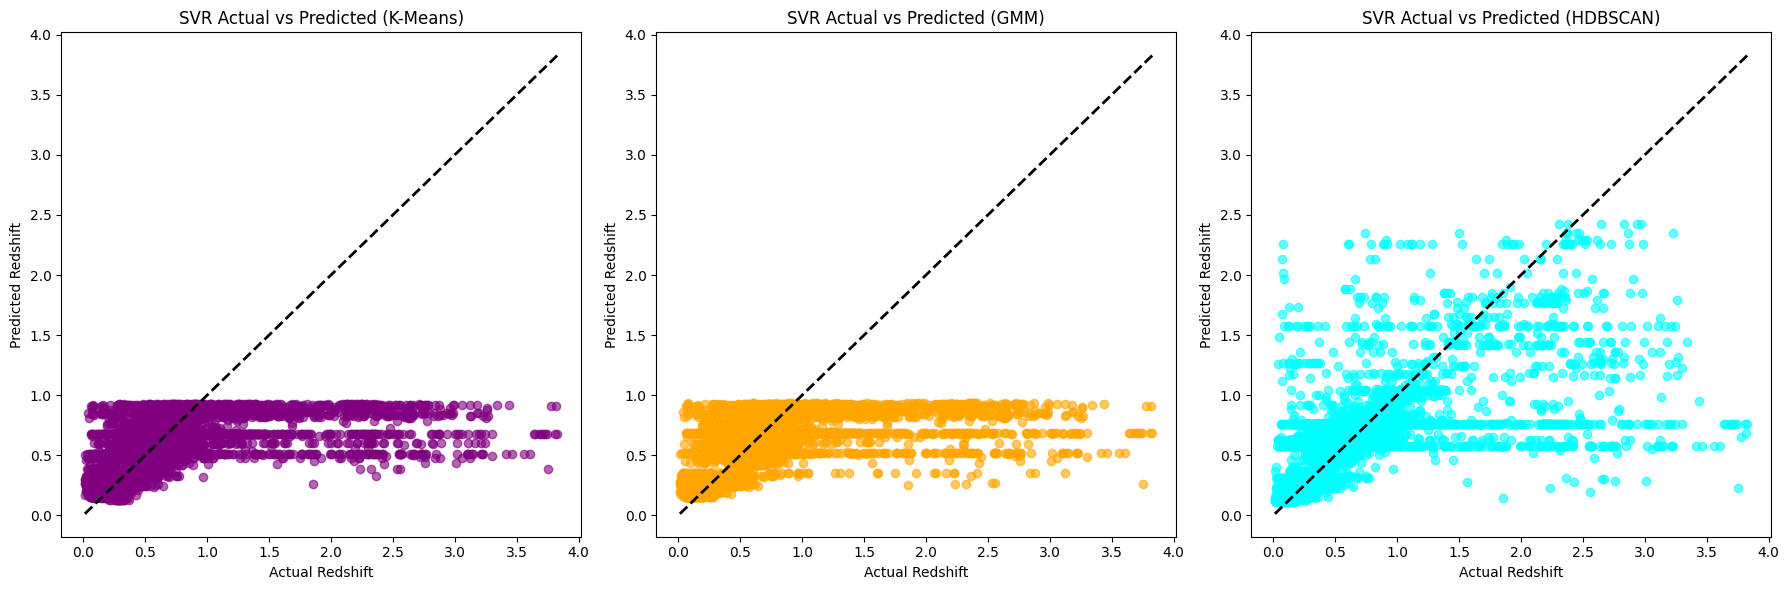

SVR Regression Results:
CLUSTER_KMEANS - MSE: 0.227899, R2: 0.281111
CLUSTER_GMM - MSE: 0.226127, R2: 0.286701
CLUSTER_HDBSCAN - MSE: 0.167378, R2: 0.472019


In [7]:
# Add-Ons for Photometric Redshift Estimation 
# Fixing UMAP Import Issue and Enhancing Preprocessing

# ---- STEP 11: Install and Import UMAP Properly ----
# Ensure proper UMAP installation: pip install umap-learn
from umap import UMAP  

umap = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap.fit_transform(df_transformed)

# ---- STEP 12: Add More Color Indices (Using Flux Values) ----
df_clean['u_g'] = df_clean['g_flux'] - df_clean['r_flux']
df_clean['g_r'] = df_clean['r_flux'] - df_clean['i_flux']
df_clean['r_i'] = df_clean['i_flux'] - df_clean['y_flux']
df_clean['i_z'] = df_clean['y_flux'] - df_clean['z_flux']

# ---- STEP 13: Additional Clustering (HDBSCAN) for SVR Comparison ----
try:
    from hdbscan import HDBSCAN
except ImportError:
    print("HDBSCAN not installed. Use: pip install hdbscan")
    raise

hdbscan = HDBSCAN(min_cluster_size=8)
df_clean['cluster_hdbscan'] = hdbscan.fit_predict(X_umap)

# ---- STEP 14: SVR Regression for Redshift Estimation ----
from sklearn.svm import SVR
svr_results = {}

for cluster_type in ['cluster_kmeans', 'cluster_gmm', 'cluster_hdbscan']:
    df_temp = pd.get_dummies(df_clean, columns=[cluster_type], prefix=[f'clust_{cluster_type}'])
    X = df_temp.drop(columns=['specz_redshift'])
    y = df_temp['specz_redshift']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    svr_results[cluster_type] = {'MSE': mse, 'R2': r2, 'y_pred': y_pred}

# ---- STEP 15: Plot SVR Results ----
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
titles = ['K-Means', 'GMM', 'HDBSCAN']
colors = ['purple', 'orange', 'cyan']

for i, cluster_type in enumerate(svr_results.keys()):
    ax[i].scatter(y_test, svr_results[cluster_type]['y_pred'], alpha=0.6, color=colors[i])
    ax[i].set_title(f'SVR Actual vs Predicted ({titles[i]})')
    ax[i].set_xlabel('Actual Redshift')
    ax[i].set_ylabel('Predicted Redshift')
    ax[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

plt.tight_layout()
plt.show()

# ---- Print SVR Performance Metrics ----
print('SVR Regression Results:')
for cluster_type, metrics in svr_results.items():
    print(f"{cluster_type.upper()} - MSE: {metrics['MSE']:.6f}, R2: {metrics['R2']:.6f}")


XGBoost , Gradient boosting and MLP NN

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
import faiss  # Faster nearest neighbor search

# ---- STEP 1: ADD MORE COLOR INDICES ----
# Verify flux columns exist before calculating new features
if all(col in df_clean.columns for col in ['g_flux', 'r_flux', 'i_flux', 'y_flux', 'z_flux']):
    df_clean['g_i'] = df_clean['g_flux'] - df_clean['i_flux']
    df_clean['r_z'] = df_clean['r_flux'] - df_clean['z_flux']
    df_clean['i_y_z'] = df_clean['i_flux'] - df_clean['y_flux'] - df_clean['z_flux']
else:
    raise ValueError("Missing required flux columns in df_clean.")

# ---- STEP 2: DEFINE FEATURES & TARGET ----
features = ['g_flux', 'r_flux', 'i_flux', 'y_flux', 'z_flux', 
            'g_r', 'r_i', 'i_y', 'y_z', 'g_i', 'r_z', 'i_y_z']

# Include cluster one-hot encoding for different clustering techniques
if 'cluster_kmeans' in df_clean.columns and 'cluster_gmm' in df_clean.columns and 'cluster_hdbscan' in df_clean.columns:
    df_encoded = pd.get_dummies(df_clean, columns=['cluster_kmeans', 'cluster_gmm', 'cluster_hdbscan'], 
                                prefix=['clust_kmeans', 'clust_gmm', 'clust_hdbscan'])
else:
    raise ValueError("Cluster columns are missing in df_clean.")

X = df_encoded[features + [col for col in df_encoded.columns if col.startswith('clust_')]]
y = df_encoded['specz_redshift']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---- STEP 3: APPLY XGBOOST ----
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb:.6f}, R2: {r2_xgb:.6f}")

# ---- STEP 4: APPLY GRADIENT BOOSTING ----
gbr = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)

mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"Gradient Boosting - MSE: {mse_gbr:.6f}, R2: {r2_gbr:.6f}")

# ---- STEP 5: TRY MLP NEURAL NETWORK ----
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP Neural Net - MSE: {mse_mlp:.6f}, R2: {r2_mlp:.6f}")

# ---- STEP 6: OPTIONAL - FASTER NEAREST NEIGHBOR SEARCH FOR DBSCAN ----
index = faiss.IndexFlatL2(X_train.shape[1])  # L2 distance (Euclidean)
index.add(X_train.astype('float32'))  # FAISS requires float32
_, indices = index.search(X_train.astype('float32'), k=5)  # Find 5 nearest neighbors


XGBoost - MSE: 0.099036, R2: 0.687598
Gradient Boosting - MSE: 0.112597, R2: 0.644823
MLP Neural Net - MSE: 0.154431, R2: 0.512862


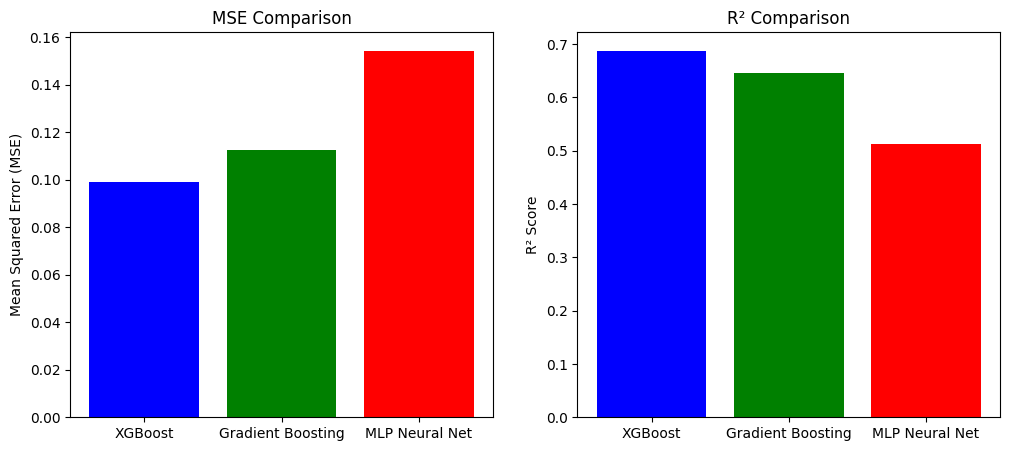

In [9]:
# ---- PLOT COMPARISON ----
models = ['XGBoost', 'Gradient Boosting', 'MLP Neural Net']
mse_scores = [mse_xgb, mse_gbr, mse_mlp]
r2_scores = [r2_xgb, r2_gbr, r2_mlp]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# MSE Plot
ax[0].bar(models, mse_scores, color=['blue', 'green', 'red'])
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_title("MSE Comparison")

# R2 Score Plot
ax[1].bar(models, r2_scores, color=['blue', 'green', 'red'])
ax[1].set_ylabel("R² Score")
ax[1].set_title("R² Comparison")

plt.show()


Fine Tuning XGBoost Hyper-Parameters

In [10]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# ---- XGBOOST HYPERPARAMETER TUNING ----
xgb_params = {
    'n_estimators': [200, 300, 500],  # More trees → better accuracy, but slower
    'learning_rate': [0.01, 0.05, 0.1],  # Lower = slower but more stable
    'max_depth': [5, 7, 9],  # Deeper trees can learn more but risk overfitting
    'subsample': [0.8, 1.0],  # Prevents overfitting by using a fraction of data per tree
    'colsample_bytree': [0.8, 1.0]  # Randomly selects features per tree to prevent overfitting
}

xgb = XGBRegressor(random_state=42)
xgb_grid = GridSearchCV(xgb, xgb_params, cv=3, scoring='r2', verbose=2, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Best model
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Tuned XGBoost - Best Params: {xgb_grid.best_params_}")
print(f"Tuned XGBoost - MSE: {mse_xgb:.6f}, R2: {r2_xgb:.6f}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  26.8s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  27.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  27.7s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  28.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=  28.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=  31.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=  36.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=  36.4s
[CV] END 

Emsemble (XGBoost + RF)

Stacking Ensemble - MSE: 0.092646, R2: 0.707756


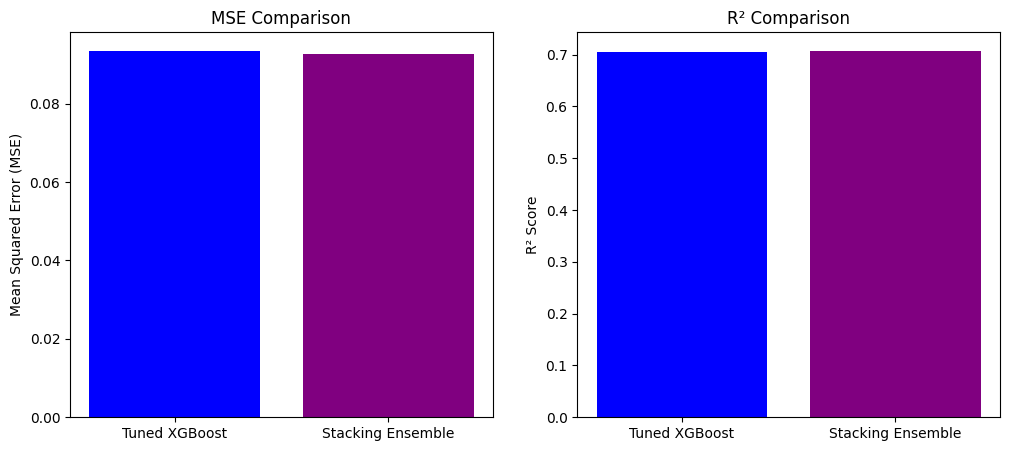

In [11]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge  # Final meta-learner

# Define base models
base_models = [
    ('xgb', best_xgb),  # Best tuned XGBoost
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, random_state=42))
]

# Stacking Ensemble
stacking_model = StackingRegressor(estimators=base_models, final_estimator=Ridge())

# Train Stacking Model
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

# Evaluate
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Ensemble - MSE: {mse_stack:.6f}, R2: {r2_stack:.6f}")


# ---- PLOT COMPARISON ----
models = ['Tuned XGBoost', 'Stacking Ensemble']
mse_scores = [mse_xgb, mse_stack]
r2_scores = [r2_xgb, r2_stack]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# MSE Plot
ax[0].bar(models, mse_scores, color=['blue', 'purple'])
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_title("MSE Comparison")

# R2 Score Plot
ax[1].bar(models, r2_scores, color=['blue', 'purple'])
ax[1].set_ylabel("R² Score")
ax[1].set_title("R² Comparison")

plt.show()


Graph Based learning 

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

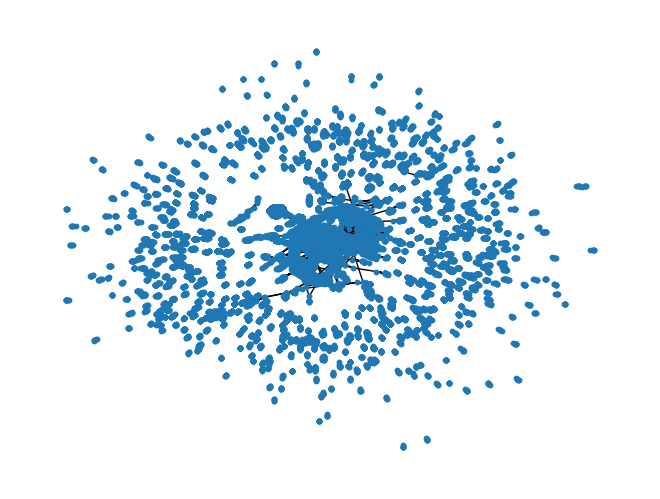

In [ ]:
import networkx as nx
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import mean_squared_error, r2_score

# ---- CREATE A KNN GRAPH ----
knn_graph = kneighbors_graph(X_train, n_neighbors=5, mode='connectivity', include_self=False)

# Convert to NetworkX Graph
G = nx.from_scipy_sparse_array(knn_graph)

# Visualize Graph Structure
nx.draw(G, node_size=10)

# ---- GRAPH-BASED REDSHIFT ESTIMATION ----
kr = KernelRidge(alpha=1.0, kernel='rbf')  # RBF kernel smooths over the graph
kr.fit(X_train, y_train)  # Train using photometric data

y_pred_graph = kr.predict(X_test)  # Predict redshift

# Evaluate Performance
mse_graph = mean_squared_error(y_test, y_pred_graph)
r2_graph = r2_score(y_test, y_pred_graph)

print(f"Graph-Based Kernel Ridge Regression - MSE: {mse_graph:.6f}, R2: {r2_graph:.6f}")


Hybrid Graph based and XG Boost

In [ ]:
# ---- USE GRAPH-BASED REDSHIFT AS A FEATURE ----
df_clean['graph_pred_redshift'] = kr.predict(X)  # ✅ FIXED: Use Kernel Ridge Regression Predictions

# Retrain XGBoost with Graph-Enhanced Features
X_new = df_clean.drop(columns=['specz_redshift'])  # Keep everything except actual redshift
y_new = df_clean['specz_redshift']

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.2, random_state=42)

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=7, random_state=42)
xgb.fit(X_train_new, y_train_new)

y_pred_xgb_new = xgb.predict(X_test_new)

mse_xgb_new = mean_squared_error(y_test_new, y_pred_xgb_new)
r2_xgb_new = r2_score(y_test_new, y_pred_xgb_new)

print(f"Hybrid Graph + XGBoost Model - MSE: {mse_xgb_new:.6f}, R2: {r2_xgb_new:.6f}")

# ---- PLOT COMPARISON ----
models = ['Stacking Ensemble', 'Graph-Based Model', 'Hybrid Graph + XGBoost']
mse_scores = [mse_stack, mse_graph, mse_xgb_new]
r2_scores = [r2_stack, r2_graph, r2_xgb_new]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# MSE Plot
ax[0].bar(models, mse_scores, color=['purple', 'orange', 'blue'])
ax[0].set_ylabel("Mean Squared Error (MSE)")
ax[0].set_title("MSE Comparison")

# R2 Score Plot
ax[1].bar(models, r2_scores, color=['purple', 'orange', 'blue'])
ax[1].set_ylabel("R² Score")
ax[1].set_title("R² Comparison")

plt.show()


NameError: name 'lp' is not defined